# Calibrate Camera Response for the visible camera

In [1]:
import sys
sys.path.append('../')

In [2]:
import time
import threading
from tqdm import tqdm

import cv2
import numpy as np
import ipywidgets as wd
from IPython import display
import matplotlib.pyplot as plt
%matplotlib widget

from skimage.transform import resize
from skimage.exposure import rescale_intensity, equalize_adapthist, equalize_hist

import dlipower
from thorlabs_elliptec import ELLx
from cameras.ids_ueye import uEye
from cameras.lucid_swir import LucidSWIR
from cameras.boson_grabber import BosonFrameGrabber
from analog_discovery.analog_discovery_main import AnalogDiscoveryDevice

import ctypes

In [3]:
vis_cam_type = 'IDS'        # 'IDS' or 'Lucid'
if vis_cam_type == 'IDS':
    vis_cam_obj = uEye()
    vis_cam_obj.set_exposure(200)
elif vis_cam_type == 'Lucid':
    vis_cam_obj = LucidSWIR()
    vis_cam_obj.printTemperatureInfo()
    vis_cam_obj.set_fps(10)
    vis_cam_obj.set_exposure(20000)
    vis_cam_obj.set_gain(0)
else:
    raise ValueError('Invalid visible camera type')

Number of parameter sets: 1
Loaded parameter set 0
Camera initialized and has exposure range: [0.0549, 227.55620000000002] ms
Exposure set to 199.99945000000002 ms


In [4]:
ad = AnalogDiscoveryDevice()

ad.set_dc_voltage(0)

In [5]:
STAGE_POS_680nm = 0
STAGE_POS_1450nm = 31
STAGE_POS_SP700 = 62
STAGE_POS_LP700 = 93

stage = ELLx("/dev/ttyUSB0")

## Capture data for Camera Response Calibration

In [6]:
curr_stage_pos = STAGE_POS_SP700
stage.move_absolute_raw(curr_stage_pos, True)

In [7]:
ad.set_dc_voltage(5.0)

In [8]:
vis_cam_obj.set_fps(10)

min_exposure_setting = 100
max_exposure_setting = 100000

num_frames_vis = 1000
print(f"Collecting {num_frames_vis} visible frames with exposure ranging from {min_exposure_setting} to {max_exposure_setting}")
vis_frames = []
vis_tstamps = []
vis_exposures = []
pbar = tqdm(range(num_frames_vis))
for i in pbar:
    exposure_val = min_exposure_setting + (max_exposure_setting - min_exposure_setting) * i / num_frames_vis
    actual_exposure_val = vis_cam_obj.set_exposure(exposure_val)
    pbar.set_description(f"Exposure: {actual_exposure_val:.3f}")
    frame = vis_cam_obj.getNextImage()
    vis_frames.append(frame)
    vis_tstamps.append(time.time())
    vis_exposures.append(actual_exposure_val)
vis_frames = np.stack(vis_frames, axis=-1)
vis_tstamps = np.array(vis_tstamps)
vis_exposures = np.array(vis_exposures)

output_filename = f'../data/visible_video_{num_frames_vis}_{time.time()}_crf.npz'
np.savez(output_filename, vis_frames=vis_frames, vis_tstamps=vis_tstamps, vis_exposures=vis_exposures)

Set acquisition frame rate to 10.0


Exposure: 99.576:   0%|          | 0/1000 [00:00<?, ?it/s]

Set exposure time to 99.576


Exposure: 99.576:   0%|          | 1/1000 [00:00<14:44,  1.13it/s]

Set exposure time to 204.952


Exposure: 204.952:   0%|          | 2/1000 [00:01<14:59,  1.11it/s]

Set exposure time to 297.16


Exposure: 297.160:   0%|          | 3/1000 [00:02<14:55,  1.11it/s]

Set exposure time to 402.536


Exposure: 402.536:   0%|          | 4/1000 [00:03<14:54,  1.11it/s]

Set exposure time to 494.736


Exposure: 494.736:   0%|          | 5/1000 [00:04<14:54,  1.11it/s]

Set exposure time to 600.112


Exposure: 600.112:   1%|          | 6/1000 [00:05<15:05,  1.10it/s]

Set exposure time to 705.488


Exposure: 705.488:   1%|          | 7/1000 [00:06<14:54,  1.11it/s]

Set exposure time to 797.696


Exposure: 797.696:   1%|          | 8/1000 [00:07<14:47,  1.12it/s]

Set exposure time to 903.072


Exposure: 903.072:   1%|          | 9/1000 [00:08<14:54,  1.11it/s]

Set exposure time to 995.272


Exposure: 995.272:   1%|          | 10/1000 [00:09<14:52,  1.11it/s]

Set exposure time to 1100.648


Exposure: 1100.648:   1%|          | 11/1000 [00:09<15:18,  1.08it/s]

Set exposure time to 1192.856


Exposure: 1192.856:   1%|          | 12/1000 [00:10<15:20,  1.07it/s]

Set exposure time to 1298.232


Exposure: 1298.232:   1%|▏         | 13/1000 [00:11<15:14,  1.08it/s]

Set exposure time to 1403.608


Exposure: 1403.608:   1%|▏         | 14/1000 [00:12<14:53,  1.10it/s]

Set exposure time to 1495.808


Exposure: 1495.808:   2%|▏         | 15/1000 [00:13<15:18,  1.07it/s]

Set exposure time to 1601.184


Exposure: 1601.184:   2%|▏         | 16/1000 [00:14<15:14,  1.08it/s]

Set exposure time to 1693.392


Exposure: 1693.392:   2%|▏         | 17/1000 [00:15<15:05,  1.09it/s]

Set exposure time to 1798.768


Exposure: 1798.768:   2%|▏         | 18/1000 [00:16<15:00,  1.09it/s]

Set exposure time to 1904.144


Exposure: 1904.144:   2%|▏         | 19/1000 [00:17<14:50,  1.10it/s]

Set exposure time to 1996.344


Exposure: 1996.344:   2%|▏         | 20/1000 [00:18<15:22,  1.06it/s]

Set exposure time to 2101.72


Exposure: 2101.720:   2%|▏         | 21/1000 [00:19<15:24,  1.06it/s]

Set exposure time to 2193.928


Exposure: 2193.928:   2%|▏         | 22/1000 [00:20<15:28,  1.05it/s]

Set exposure time to 2299.304


Exposure: 2299.304:   2%|▏         | 23/1000 [00:21<15:37,  1.04it/s]

Set exposure time to 2391.504


Exposure: 2391.504:   2%|▏         | 24/1000 [00:22<15:29,  1.05it/s]

Set exposure time to 2496.88


Exposure: 2496.880:   2%|▎         | 25/1000 [00:23<15:07,  1.07it/s]

Set exposure time to 2602.256


Exposure: 2602.256:   3%|▎         | 26/1000 [00:23<15:01,  1.08it/s]

Set exposure time to 2694.464


Exposure: 2694.464:   3%|▎         | 27/1000 [00:25<15:36,  1.04it/s]

Set exposure time to 2799.84


Exposure: 2799.840:   3%|▎         | 28/1000 [00:25<15:30,  1.04it/s]

Set exposure time to 2892.04


Exposure: 2892.040:   3%|▎         | 29/1000 [00:26<15:18,  1.06it/s]

Set exposure time to 2997.416


Exposure: 2997.416:   3%|▎         | 30/1000 [00:27<15:01,  1.08it/s]

Set exposure time to 3102.792


Exposure: 3102.792:   3%|▎         | 31/1000 [00:28<14:55,  1.08it/s]

Set exposure time to 3195.0


Exposure: 3195.000:   3%|▎         | 32/1000 [00:29<14:48,  1.09it/s]

Set exposure time to 3300.376


Exposure: 3195.000:   3%|▎         | 32/1000 [00:30<15:21,  1.05it/s]


KeyboardInterrupt: 

In [13]:
## IDS
vis_cam_obj.set_fps(10)
ad.set_dc_voltage(5.0)
time.sleep(0.5)

min_exposure_setting = 100
max_exposure_setting = 200

vis_cam_obj.set_exposure(min_exposure_setting)
min_exp_img_0 = vis_cam_obj.getNextImage()
ad.set_dc_voltage(2.5)
time.sleep(0.5)
# vis_cam_obj.set_exposure(max_exposure_setting)
max_exp_img_0 = vis_cam_obj.getNextImage()

Target frame rate: 10.0, actual frame rate: 9.999856627055609
Changed frame rate to 9.999856627055609 and camera now has exposure range: [0.0549, 99.82910000000001] ms
Exposure value 99.82910000000001 is greater than maximum 99.82910000000001
Exposure set to 99.82910000000001 ms


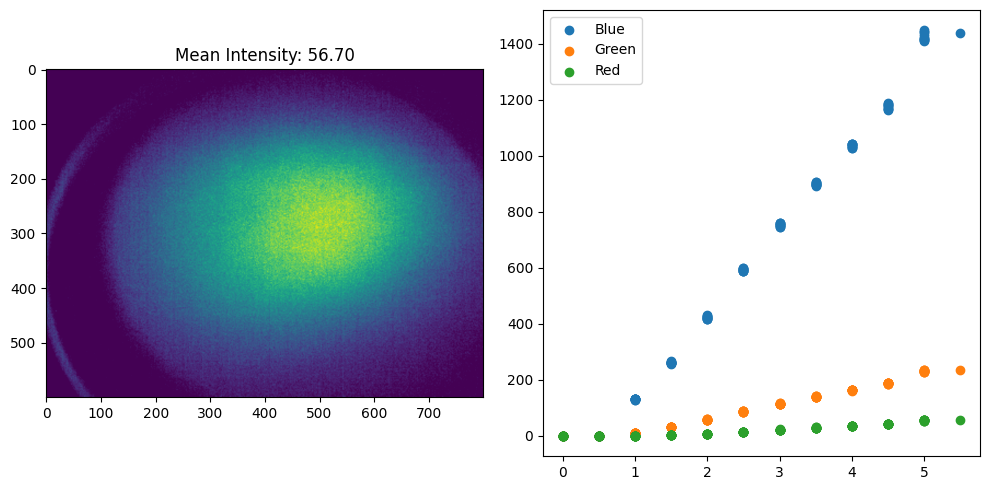

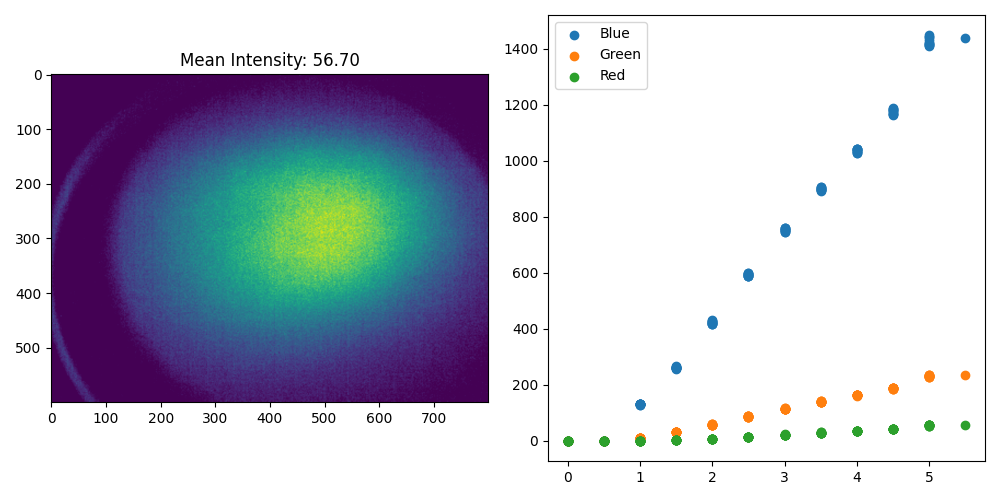

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vis_cam_obj.set_exposure(0.1)

mean_vals_b = []
mean_vals_g = []
mean_vals_r = []
voltage_vals = []
cnt = 1

curr_voltage = 0.0
ad.set_dc_voltage(curr_voltage)

while True:
    if cnt % 10 == 0:
        curr_voltage += 0.5
        ad.set_dc_voltage(np.minimum(curr_voltage, 5.0))
        time.sleep(0.5)
    vis_img = vis_cam_obj.getNextImage()

    vis_img_color = cv2.cvtColor(vis_img, cv2.COLOR_BAYER_RGGB2BGR)
    mean_vals_b.append(np.mean(vis_img_color[..., 0]))
    mean_vals_g.append(np.mean(vis_img_color[..., 1]))
    mean_vals_r.append(np.mean(vis_img_color[..., 2]))
    voltage_vals.append(curr_voltage)

    ax[0].clear()
    ax[1].clear()
    ax[0].imshow(vis_img_color[..., 2])
    ax[0].set_title(f'Mean Intensity: {np.mean(vis_img_color[..., 2]):.2f}')
    ax[1].scatter(voltage_vals, mean_vals_b, label='Blue')
    ax[1].scatter(voltage_vals, mean_vals_g, label='Green')
    ax[1].scatter(voltage_vals, mean_vals_r, label='Red')
    ax[1].legend()
    plt.tight_layout()
    display.clear_output(wait=True)
    display.display(plt.gcf())

    cnt += 1
    if curr_voltage > 5.0:
        break


In [9]:
from scipy.io import loadmat

crf_path = "../crf.mat"
intensity_to_irradiance = loadmat(crf_path)["crf"]


In [10]:
exposure_val = 0.05 * 1e-3
mean_intensity_vals_b = (np.array(mean_vals_b) / 16).astype(np.uint8)
mean_intensity_vals_g = (np.array(mean_vals_g) / 16).astype(np.uint8)
mean_intensity_vals_r = (np.array(mean_vals_r) / 16).astype(np.uint8)

mean_irradiance_vals_b = np.exp(intensity_to_irradiance[mean_intensity_vals_b, 0] - np.log(exposure_val))
mean_irradiance_vals_g = np.exp(intensity_to_irradiance[mean_intensity_vals_g, 1] - np.log(exposure_val))
mean_irradiance_vals_r = np.exp(intensity_to_irradiance[mean_intensity_vals_r, 2] - np.log(exposure_val))


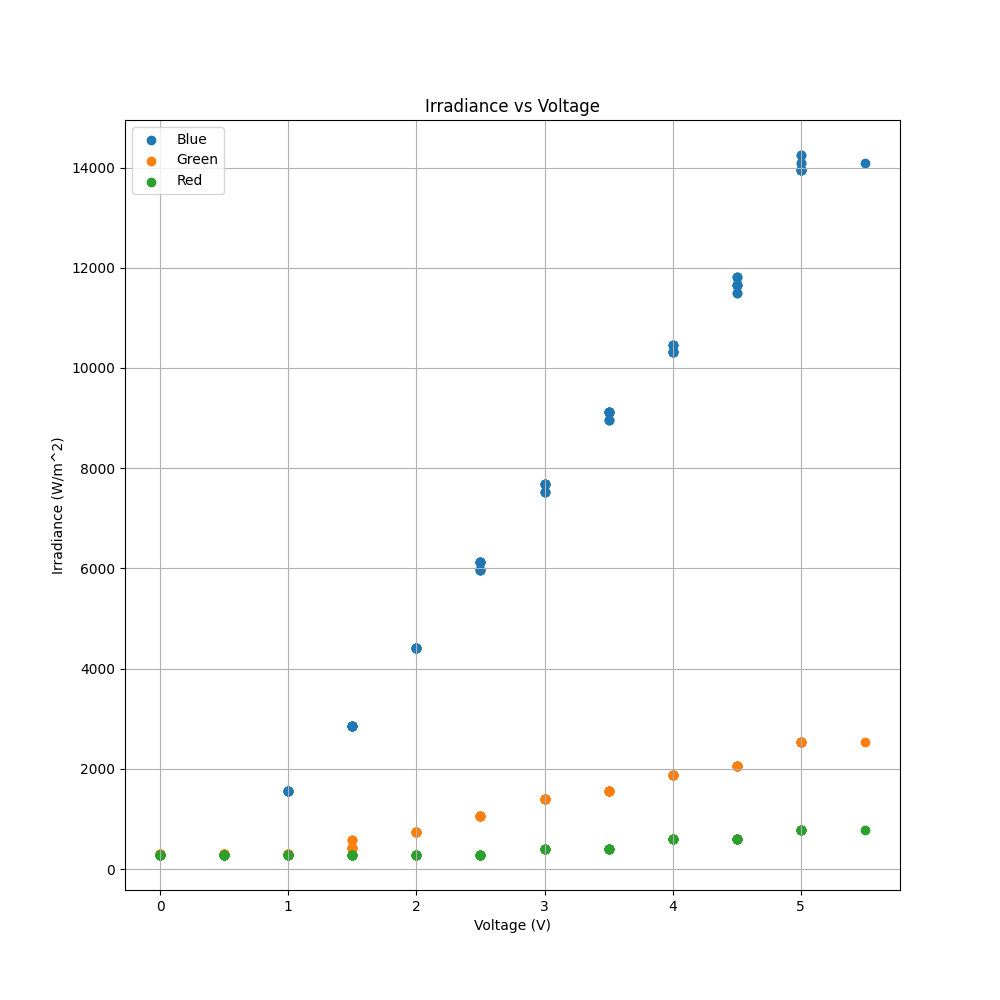

In [11]:
plt.figure(figsize=(10, 10))
plt.scatter(voltage_vals, mean_irradiance_vals_b, label='Blue')
plt.scatter(voltage_vals, mean_irradiance_vals_g, label='Green')
plt.scatter(voltage_vals, mean_irradiance_vals_r, label='Red')
plt.legend()
plt.xlabel('Voltage (V)')
plt.ylabel('Irradiance (W/m^2)')
plt.title('Irradiance vs Voltage')
plt.grid()
plt.show()

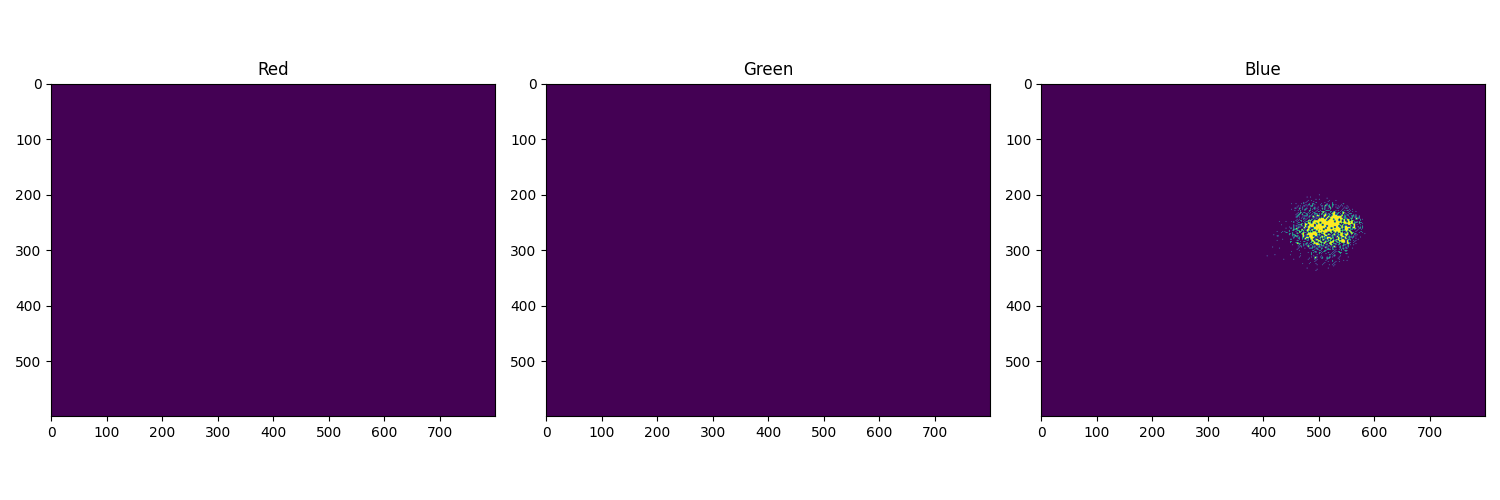

In [12]:
mask_r = vis_img_color[..., 2] >= 4090
mask_g = vis_img_color[..., 1] >= 4090
mask_b = vis_img_color[..., 0] >= 4090

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mask_r)
ax[0].set_title('Red')
ax[1].imshow(mask_g)
ax[1].set_title('Green')
ax[2].imshow(mask_b)
ax[2].set_title('Blue')
plt.tight_layout()
plt.show()

In [13]:
## LUCID
vis_cam_obj.set_fps(10)
ad.set_dc_voltage(0)

min_exposure_setting = 100
max_exposure_setting = 100000

vis_cam_obj.set_exposure(min_exposure_setting)
min_exp_img_0 = vis_cam_obj.getNextImage()
vis_cam_obj.set_exposure(max_exposure_setting)
max_exp_img_0 = vis_cam_obj.getNextImage()

Set acquisition frame rate to 10.0
Set exposure time to 99.576
Clipping requested exposure time to max value of 99811.616
Set exposure time to 99811.616


In [28]:
min_exp_img_0_color = np.uint8(cv2.cvtColor(min_exp_img_0, cv2.COLOR_BAYER_RGGB2RGB) // 16)
max_exp_img_0_color = np.uint8(cv2.cvtColor(max_exp_img_0, cv2.COLOR_BAYER_RGGB2RGB) // 16)

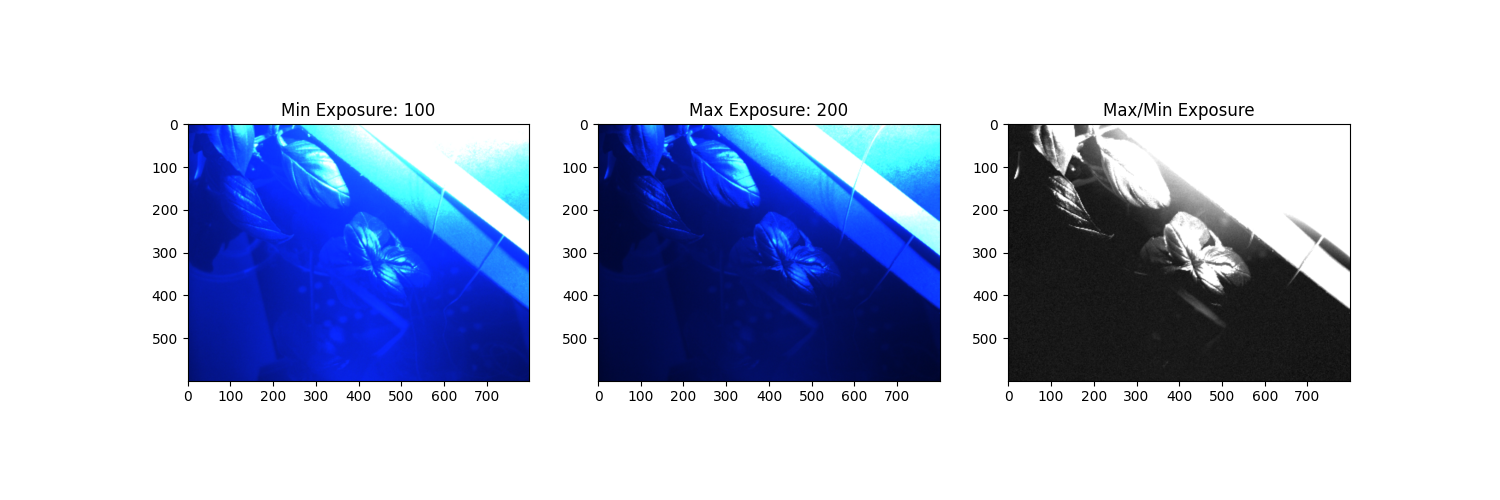

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(min_exp_img_0_color)
ax[0].set_title(f'Min Exposure: {min_exposure_setting}')
ax[1].imshow(max_exp_img_0_color)
ax[1].set_title(f'Max Exposure: {max_exposure_setting}')
ratio = max_exp_img_0_color[..., 2] / min_exp_img_0_color[..., 2]
ax[2].imshow(ratio, cmap='gray')
ax[2].set_title('Max/Min Exposure')
plt.show()

In [32]:
ratio[400:, :200].mean()

0.44150441191584167

In [ ]:
curr_stage_pos = STAGE_POS_SP700
stage.move_absolute_raw(curr_stage_pos, True)